## Imports

In [44]:
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from src.model.ITrackerData import TrainITrackerData
from src.model.ITrackerData import TestITrackerData
from src.model.ITrackerModel import ITrackerModel
from src.model.EyeTracker import EyeTracker
from src.model.ITrackerData import ITrackerData
from torch.utils.data import random_split
import torch.optim.lr_scheduler as lr_scheduler


In [45]:
#dataset_file = Path("../data/finetuning/calibrate.npy")
base_checkpoint = Path("../data/uploadable_checkpoints/best_gazecapture_model.pth")
finetune_checkpoint = Path("../data/finetuning/finetunned_model.pth")

## Exploration

In [46]:
# Load eye tracker model for croppings
itracker_checkpoint = str(Path('../data/uploadable_checkpoints/best_gazecapture_model.pth'))
torch_device = 'cuda'
normalizer_file = str(Path('../data/numpy/normalize_mean.npy'))
detector_checkpoint = str(Path('../data/uploadable_checkpoints/face_landmarker_v2_with_blendshapes.task'))
tracker = EyeTracker(itracker_checkpoint, torch_device, normalizer_file, detector_checkpoint)

In [47]:
def get_crops(image_samples, pixel_samples):
    images = image_samples
    face_crops, left_eye_crops, right_eye_crops, face_masks = [], [], [], []
    for i, image in enumerate(images):
        try:
            face_crop, left_eye_crop, right_eye_crop, face_mask = [x.cpu().numpy() for x in tracker.prepare_data(*tracker.get_item_crops(image))]
            face_crop, left_eye_crop, right_eye_crop, face_mask = face_crop[0], left_eye_crop[0], right_eye_crop[0], face_mask[0]
        except Exception:
            print(f"Found problematic image: id:{i}")
            pixel_samples = np.delete(pixel_samples, i, axis=0)
            continue
        face_crops.append(face_crop)
        left_eye_crops.append(left_eye_crop)
        right_eye_crops.append(right_eye_crop)
        face_masks.append(face_mask)
    face_crops, left_eye_crops, right_eye_crops, face_masks = np.array(face_crops), np.array(left_eye_crops), np.array(right_eye_crops), np.array(face_masks)
    face_crops, left_eye_crops, right_eye_crops = [np.transpose(x, (0,2,3,1)) for x in [face_crops, left_eye_crops, right_eye_crops]]
    return [face_crops, left_eye_crops, right_eye_crops, face_masks, pixel_samples]

## Training

In [48]:
# Hyperparameters
device = torch.device("cuda:0")
num_workers = 2
pin_memory = True

lr = 1e-3
batch_size = 40
print_per_epoch = 10

model = ITrackerModel().to(device)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr)
scaler = torch.cuda.amp.GradScaler()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [34]:
# Freeze all but last layer
#for param in model.parameters():
#    param.requires_grad = False 
    
#for param in model.fc[2].parameters():
#    param.requires_grad = True 
    
#torch.nn.init.xavier_uniform(model.fc[2].weight)
#model.fc[2].bias.data.fill_(0.01)

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.requires_grad)

In [49]:
#Load finetuning data
files = ['../data/finetuning/calibrate.npy',
         '../data/finetuning/calibrate_Jen.npy',
         '../data/finetuning/calibrate_Eli.npy',
         '../data/finetuning/calibrate_Alex.npy']

image_samples = None
pixel_samples = None
for file in files:
    with open(str(Path(file)), 'rb') as f:
        if image_samples is None:
            pixel_samples = np.load(f)
            image_samples = np.load(f)
        else:
            pixel_samples = np.append(pixel_samples, np.load(f), axis=0)
            image_samples = np.append(image_samples, np.load(f), axis=0)
data = get_crops(image_samples, pixel_samples)

Found problematic image: id:1036
Found problematic image: id:1043
Found problematic image: id:2667
Found problematic image: id:2670
Found problematic image: id:2671
Found problematic image: id:2672
Found problematic image: id:2673
Found problematic image: id:2674
Found problematic image: id:2676
Found problematic image: id:2677
Found problematic image: id:2678
Found problematic image: id:2679
Found problematic image: id:2680
Found problematic image: id:2681
Found problematic image: id:2682
Found problematic image: id:2683
Found problematic image: id:2684
Found problematic image: id:2685
Found problematic image: id:2686
Found problematic image: id:2687
Found problematic image: id:2688
Found problematic image: id:2689
Found problematic image: id:2690
Found problematic image: id:2691
Found problematic image: id:2692
Found problematic image: id:2693
Found problematic image: id:2694
Found problematic image: id:2695
Found problematic image: id:2696
Found problematic image: id:2697
Found prob

In [50]:
# Create datasets for training & validation
base_set = ITrackerData(data)
# reduce training_set size for intentional overfitting
training_set, validation_set, _ = random_split(base_set, [0.8, 0.2, 0.0])

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

In [51]:
def train_one_epoch(epoch_index):
    running_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        faces, eyes_left, eyes_right, face_masks, labels = data

        # Send all tensors to device
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(faces, eyes_left, eyes_right, face_masks)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        # Scale gradient
        scaler.scale(loss).backward()

        # Update Optimizer
        scaler.step(optimizer)
        scaler.update()

        # Gather data and report
        running_loss += loss.item() * len(data)  
          
    # Update scheduler at end of epocj
    scheduler.step()
    
    return running_loss / len(training_set)

In [52]:
epoch_number = 0

EPOCHS = 15

best_vloss = 1_000_000.

metric_dict = {"train_loss": [], "val_loss": []}

def run(epoch_number, EPOCHS, best_vloss, metric_dict):
    for epoch in range(EPOCHS):

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                faces, eyes_left, eyes_right, face_masks, labels = vdata
                # Send all tensors to device
                faces, eyes_left, eyes_right, face_masks, labels = \
                    faces.to(device),\
                    eyes_left.to(device),\
                    eyes_right.to(device),\
                    face_masks.to(device),\
                    labels.to(device)
                voutputs = model(faces, eyes_left, eyes_right, face_masks)
                vloss = loss_fn(voutputs, labels)
                running_vloss += vloss * len(vdata)

        avg_vloss = running_vloss / len(validation_set)

        # Log the running loss averaged per batch
        # for both training and validation
        print(f"Epoch: {epoch_number + 1}")
        print(f"Train Loss: {avg_loss}")
        print(f"Val Loss: {avg_vloss}")

        # Record metrics for visualization
        metric_dict["train_loss"].append(avg_loss)
        metric_dict["val_loss"].append(avg_vloss.item())
        epoch_number += 1

In [53]:
run(epoch_number, EPOCHS, best_vloss, metric_dict)

Epoch: 1
Train Loss: 65128.602833137425
Val Loss: 60289.19140625
Epoch: 2
Train Loss: 28809.981533180166
Val Loss: 20545.93359375
Epoch: 3
Train Loss: 16280.616981292744
Val Loss: 14575.1962890625
Epoch: 4
Train Loss: 13580.481043124866
Val Loss: 18136.884765625
Epoch: 5
Train Loss: 12037.67315565559
Val Loss: 12212.97265625
Epoch: 6
Train Loss: 10235.094725936364
Val Loss: 10464.5029296875
Epoch: 7
Train Loss: 9527.198000290527
Val Loss: 9125.41796875
Epoch: 8
Train Loss: 8168.0082549690105
Val Loss: 8348.5146484375
Epoch: 9
Train Loss: 6763.552684910304
Val Loss: 7371.0419921875
Epoch: 10
Train Loss: 5714.065449097697
Val Loss: 5668.71142578125
Epoch: 11
Train Loss: 4344.287432878286
Val Loss: 4919.99560546875
Epoch: 12
Train Loss: 4121.340265765254
Val Loss: 4773.9287109375
Epoch: 13
Train Loss: 3992.1482319188794
Val Loss: 4695.73974609375
Epoch: 14
Train Loss: 3848.20943957543
Val Loss: 4641.41943359375
Epoch: 15
Train Loss: 3770.4894291648857
Val Loss: 4347.32373046875


In [55]:
torch.save(model.state_dict(), finetune_checkpoint)

Text(0, 0.5, 'loss')

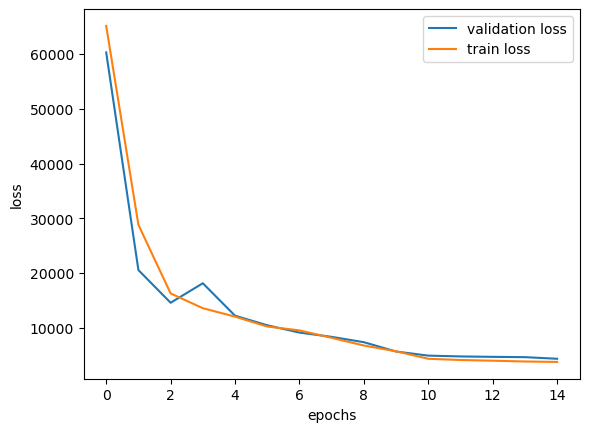

In [56]:
plt.plot(metric_dict["val_loss"], label = "validation loss")
plt.plot(metric_dict["train_loss"], label = "train loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

In [54]:
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        faces, eyes_left, eyes_right, face_masks, labels = vdata
        # Send all tensors to device
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        voutputs = model(faces, eyes_left, eyes_right, face_masks)
        id = 1
        print(voutputs[id])
        print(labels[id])
        plt.imshow(faces.cpu()[id].permute(1,2,0))
        break

KeyboardInterrupt: 

tensor([[ 2.1592e+03,  4.0275e+02],
        [ 3.2340e+02,  3.6236e+02],
        [ 1.6272e+02,  7.9025e+02],
        [ 1.3849e+03,  5.0246e+02],
        [ 1.8874e+03,  6.7244e+02],
        [ 2.0893e+03,  3.0423e+02],
        [ 1.9294e+03,  9.6660e+02],
        [ 1.0766e+03, -2.0394e+00],
        [ 2.0341e+03,  1.2539e+03],
        [ 5.4759e+02,  1.1301e+03],
        [ 1.9965e+02,  1.3583e+03],
        [ 4.2580e+02,  1.0988e+03],
        [ 1.8771e+03,  1.4565e+03],
        [ 7.0583e+01,  1.5017e+02],
        [ 2.1233e+02,  1.1355e+03],
        [ 4.2163e+02,  8.7041e+02],
        [ 2.2692e+03,  1.0985e+02],
        [ 5.0419e+02,  5.1620e+02],
        [ 1.1334e+03,  2.5820e+02],
        [ 2.1633e+03,  5.4066e+02],
        [ 1.6161e+03,  2.7547e+02],
        [ 1.9528e+03,  5.1808e+02],
        [ 7.3577e+02,  2.0138e+02],
        [ 8.0550e+02,  1.3336e+03],
        [ 1.9525e+03,  3.1054e+02],
        [ 1.4439e+03,  7.6094e+02],
        [ 1.1662e+03,  3.1964e+02],
        [ 1.7131e+01,  5.421

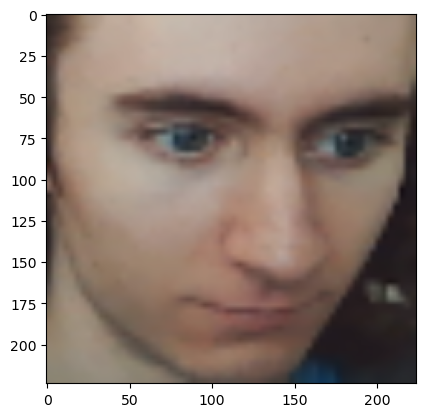

In [43]:
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        faces, eyes_left, eyes_right, face_masks, labels = vdata
        # Send all tensors to device
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        voutputs = model(faces, eyes_left, eyes_right, face_masks)
        id = 2
        print(voutputs)
        print(labels)
        plt.imshow(faces.cpu()[id].permute(1,2,0))
        break